# Compare performance of various models

We compare the performance of various models on the dataset that was used for the competition leaderboard (combining data from the public and private leaderboard). All the models are trained on a subset of the training set; performance could be improved by training on multiple folds and averaging the results.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import datetime as dt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from model_definitions import (define_model_cnn_1_min, define_model_cnn_hourly, define_model_lstm_1_min, define_model_lstm_hourly, define_model_transformer_1_min)
from preprocessing import combine_old_and_new_data
from predict import load_models, predict_batch
from train import train_nn_models
import time
from typing import Callable, Tuple
import tensorflow as tf
from plotting import plot_binned_RMSE
import matplotlib.pyplot as plt


In [2]:
# download and save data
# !wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
# !unzip public.zip
# !wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip
# !unzip private.zip
# !mkdir data
# !mv public data
# !mv private data

In [3]:
# load recent data
data_folder = "data"
solar_train = pd.read_csv(os.path.join(data_folder, "public", "solar_wind.csv"))
dst_train = pd.read_csv(os.path.join(data_folder, "public", "dst_labels.csv"))
sunspots_train = pd.read_csv(os.path.join(data_folder, "public", "sunspots.csv"))
solar_test = pd.read_csv(os.path.join(data_folder, "private", "solar_wind.csv"))
dst_test = pd.read_csv(os.path.join(data_folder, "private", "dst_labels.csv"))
sunspots_test = pd.read_csv(os.path.join(data_folder, "private", "sunspots.csv"))

In [4]:
# Load older data
solar_old = pd.read_csv(os.path.join(data_folder, "old", "solar_wind.csv"))
dst_old = pd.read_csv(os.path.join(data_folder, "old", "dst_labels.csv"))
sunspots_old = pd.read_csv(os.path.join(data_folder, "old", "sunspots.csv"))
# Merge data - train on old and recent public data, test on recent private data
solar_train_hourly = combine_old_and_new_data(solar_old, solar_train)
sunspots_train_hourly = pd.concat([sunspots_train, sunspots_old], axis=0)
dst_train_hourly = pd.concat([dst_train, dst_old], axis=0)
solar_test_hourly = solar_test.copy()
# Extract hourly data
solar_test_hourly = combine_old_and_new_data(pd.DataFrame(), solar_test)

In [5]:
# measure performance
dst_test["timedelta"] = pd.to_timedelta(dst_test["timedelta"])
# exclude times in the first week + 1 hour of dst_test
dst_test = dst_test.loc[dst_test["timedelta"] >= dt.timedelta(days=7, hours=1)].copy()
dst_test["dst_t_plus_1"] = dst_test.groupby("period")["dst"].shift(-1)

model_dict = {"cnn_1_min": "minute",  "hybrid_cnn": "hybrid", "lstm_1_min": "minute", "transformer_1_min": "minute", "transformer_hourly": "hour"}
for model in model_dict:
    output_folder = os.path.join("trained_models", model, "benchmark")
    model_t_arr, model_t_plus_1_arr, norm_df = load_models(output_folder, 1)
    freq = model_dict[model]
    if freq in ["minute", "hybrid"]:
        predictions = predict_batch(
            solar_test.copy(), sunspots_test, dst_test, model_t_arr, model_t_plus_1_arr, norm_df, freq
        )
    else:
        predictions = predict_batch(
            solar_test_hourly.copy(), sunspots_test, dst_test, model_t_arr, model_t_plus_1_arr, norm_df, freq
        )
    predictions.rename(columns={"prediction_t": model + "_prediction_t", "prediction_t_plus_1": model + "_prediction_t_plus_1"}, inplace=True)
    dst_test = pd.merge(dst_test, predictions, "left", ["timedelta", "period"])


In [6]:
loss_df = pd.DataFrame(columns=['model', 'loss_t', 'loss_t+1'])
for model in model_dict:
    valid_ind = dst_test['dst_t_plus_1'].notnull() & dst_test['dst'].notnull()
    loss_t = np.sqrt(
        mean_squared_error(dst_test.loc[valid_ind, "dst"].values, dst_test.loc[valid_ind, model + "_prediction_t"].values)
    )
    loss_t_plus_1 = np.sqrt(
        mean_squared_error(
            dst_test.loc[valid_ind, "dst_t_plus_1"].values,
            dst_test.loc[valid_ind, model + "_prediction_t_plus_1"].values,
        )
    )
    loss_df.loc[len(loss_df), :] = [model, loss_t, loss_t_plus_1]

loss_df

,model,loss_t,loss_t+1
0,cnn_1_min,12.4813,12.4337
1,hybrid_cnn,13.3233,14.912
2,lstm_1_min,13.2399,14.3598
3,transformer_1_min,13.2024,13.806
4,transformer_hourly,14.8838,14.2642


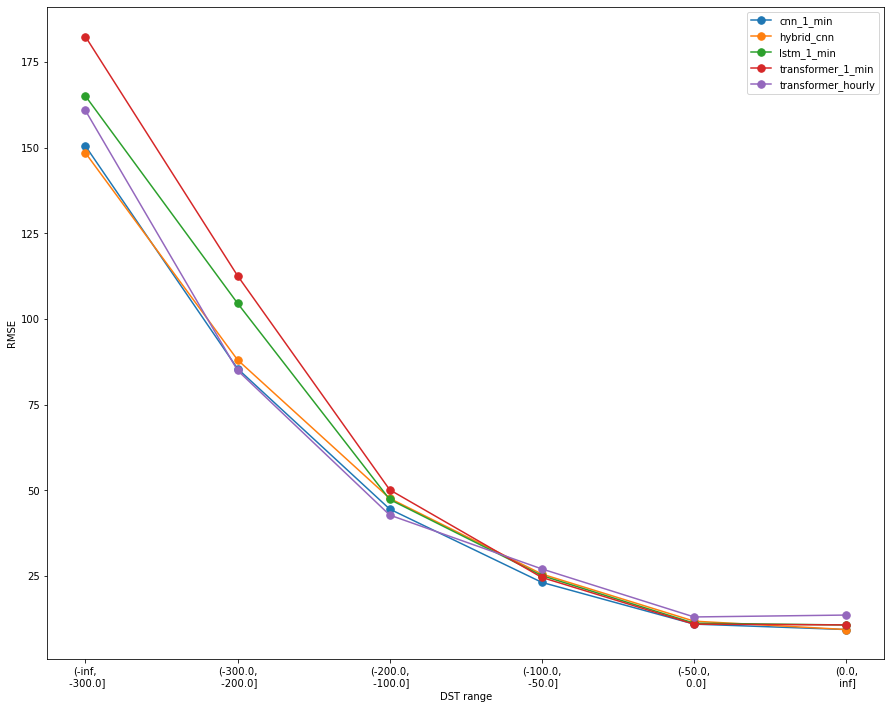

In [7]:
# plot errors in different DST ranges, time t
plt.figure(figsize=(15, 12))
bins = [-np.inf, -300, -200, -100, -50, 0, np.inf]
model_names = model_dict.keys()
for model in model_names:
    pred_col = model + "_prediction_t"
    plot_binned_RMSE(dst_test.loc[valid_ind, "dst"].values, dst_test.loc[valid_ind, pred_col].values, bins)
plt.legend(list(model_names))